- separate part count

In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation
from bitarray import bitarray
from lightgbm import LGBMClassifier

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc="progress: ")

_ = np.seterr(divide='ignore', invalid='ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def make_bitarray():
    a = bitarray(32737, endian='little')
    a.setall(True)   
    return a

In [4]:
FULL_TRAIN = False

# Preprocess

In [5]:
data_types_dict = {
    #'row_id': 'uint32',
    'timestamp': 'uint64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [6]:
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()

train_df = train_df[train_df[target] != -1].reset_index(drop=True)
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df['timestamp'] = (train_df['timestamp'] // 86400000) + 1 # days from start
train_df = train_df.astype(data_types_dict)

if FULL_TRAIN:
    train_size = 40
else:
    train_size = 24
    valid_size = 6
train_index = list(train_df.groupby('user_id').tail(train_size).index)

In [7]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 3], #, 4
    dtype={'question_id': 'int16', 'part': 'int8'}  #, 'tags': 'object'
)
train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
train_df.drop(columns=['question_id'], inplace=True)

In [8]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
user_correctness_array = np.array(cum['cumsum'] / cum['cumcount'])
user_correctness_array = user_correctness_array[train_index]
train_df.drop(columns=['lag'], inplace=True)
del cum

In [9]:
train_df["part_count"] = train_df["part"] ==1
train_df["part_count"] = train_df["part_count"].astype("int8")
train_df['part_count_lag'] = train_df.groupby('user_id')["part_count"].shift()
part1_count_array = train_df.groupby('user_id')['part_count_lag'].agg(['cumsum']).values
part1_count_array = part1_count_array[train_index] 
train_df.drop(columns=['part_count_lag', 'part_count'], inplace=True)

train_df["part_count"] = train_df["part"] ==2
train_df["part_count"] = train_df["part_count"].astype("int8")
train_df['part_count_lag'] = train_df.groupby('user_id')["part_count"].shift()
part2_count_array = train_df.groupby('user_id')['part_count_lag'].agg(['cumsum']).values
part2_count_array = part2_count_array[train_index] 
train_df.drop(columns=['part_count_lag', 'part_count'], inplace=True)

train_df["part_count"] = train_df["part"] ==3
train_df["part_count"] = train_df["part_count"].astype("int8")
train_df['part_count_lag'] = train_df.groupby('user_id')["part_count"].shift()
part3_count_array = train_df.groupby('user_id')['part_count_lag'].agg(['cumsum']).values
part3_count_array = part3_count_array[train_index] 
train_df.drop(columns=['part_count_lag', 'part_count'], inplace=True)

train_df["part_count"] = train_df["part"] ==4
train_df["part_count"] = train_df["part_count"].astype("int8")
train_df['part_count_lag'] = train_df.groupby('user_id')["part_count"].shift()
part4_count_array = train_df.groupby('user_id')['part_count_lag'].agg(['cumsum']).values
part4_count_array = part4_count_array[train_index] 
train_df.drop(columns=['part_count_lag', 'part_count'], inplace=True)

train_df["part_count"] = train_df["part"] ==5
train_df["part_count"] = train_df["part_count"].astype("int8")
train_df['part_count_lag'] = train_df.groupby('user_id')["part_count"].shift()
part5_count_array = train_df.groupby('user_id')['part_count_lag'].agg(['cumsum']).values
part5_count_array = part5_count_array[train_index] 
train_df.drop(columns=['part_count_lag', 'part_count'], inplace=True)

train_df["part_count"] = train_df["part"] ==6
train_df["part_count"] = train_df["part_count"].astype("int8")
train_df['part_count_lag'] = train_df.groupby('user_id')["part_count"].shift()
part6_count_array = train_df.groupby('user_id')['part_count_lag'].agg(['cumsum']).values
part6_count_array = part6_count_array[train_index] 
train_df.drop(columns=['part_count_lag', 'part_count'], inplace=True)

train_df["part_count"] = train_df["part"] ==7
train_df["part_count"] = train_df["part_count"].astype("int8")
train_df['part_count_lag'] = train_df.groupby('user_id')["part_count"].shift()
part7_count_array = train_df.groupby('user_id')['part_count_lag'].agg(['cumsum']).values
part7_count_array = part7_count_array[train_index] 
train_df.drop(columns=['part_count_lag', 'part_count'], inplace=True)

In [10]:
#train_df["part_first_attempt"] = train_df[["row_id", "user_id", "part"]].groupby("user_id").progress_apply(lambda x: 
#                               pd.DataFrame(np.isin(x["row_id"].values, x.drop_duplicates("part")["row_id"].values))).values
#train_df.drop("row_id", axis=1, inplace=True)

first_attempt_df = pd.read_csv("../input/riiid-additional-data/content_first_attempt.csv")
first_attempt_array = first_attempt_df.first_attempt.values
train_df["first_attempt"] = first_attempt_array
unique_attempt_array= train_df.groupby("user_id")["first_attempt"].cumsum().values
train_df["unique_attempt"] = unique_attempt_array
user_unique_agg = train_df.groupby('user_id')["unique_attempt"].agg(['max'])
user_unique_dict = user_unique_agg['max'].astype('int32').to_dict(defaultdict(int))

first_attempt_array = first_attempt_array[train_index]
unique_attempt_array = unique_attempt_array[train_index]
train_df.drop(['first_attempt', 'unique_attempt'], axis=1, inplace=True)
del first_attempt_df, user_unique_agg

In [11]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

content_count_array = train_df['content_id'].map(content_agg['count']).astype('int32').values
content_id_array = train_df['content_id'].map(content_agg['sum'] / content_agg['count']).values
content_count_array = content_count_array[train_index]
content_id_array = content_id_array[train_index]

del user_agg, content_agg

In [12]:
%%time
user_content_agg = train_df.groupby("user_id")["content_id"].unique().reset_index().set_index("user_id")

value = []
for j in user_content_agg.index:
    a = bitarray(32737, endian='little')
    a.setall(True)
    for i in user_content_agg.loc[j][0]:
        a[i] = 0
    value.append(a)
    
user_content_agg["content_exp"] = value

user_content_dict = user_content_agg["content_exp"].to_dict(defaultdict(make_bitarray))
del user_content_agg

CPU times: user 2min 27s, sys: 3.17 s, total: 2min 30s
Wall time: 2min 30s


In [13]:
train_df["count"] = 1
count_array = train_df.groupby("user_id")["count"].cumsum().values
count_array = count_array[train_index]
train_df.drop("count", axis=1, inplace=True)

In [14]:
train_df["count_inday"] = 1
count_inday_array = train_df.groupby(["user_id","timestamp"])["count_inday"].cumsum().values
count_inday_array = count_inday_array[train_index]
train_df.drop("count_inday", axis=1, inplace=True)

In [15]:
train_df = train_df.groupby('user_id').tail(train_size).reset_index(drop=True)

In [16]:
train_df['content_count'] = content_count_array
train_df['content_id'] = content_id_array
train_df['user_correctness'] = user_correctness_array
train_df['first_attempt'] = first_attempt_array
train_df['count'] = count_array
train_df['count_inday'] = count_inday_array
train_df['unique_attempt'] = unique_attempt_array
train_df['part1_count'] = part1_count_array
train_df['part2_count'] = part2_count_array
train_df['part3_count'] = part3_count_array
train_df['part4_count'] = part4_count_array
train_df['part5_count'] = part5_count_array
train_df['part6_count'] = part6_count_array
train_df['part7_count'] = part7_count_array
#train_df['part_count_std'] = np.std(train_df[["part1_count", "part2_count", "part3_count", "part4_count", "part5_count", "part6_count", "part7_count"]], axis=1)
    
part1_count_agg = train_df.groupby('user_id')["part1_count"].agg(['max'])
part2_count_agg = train_df.groupby('user_id')["part2_count"].agg(['max'])
part3_count_agg = train_df.groupby('user_id')["part3_count"].agg(['max'])
part4_count_agg = train_df.groupby('user_id')["part4_count"].agg(['max'])
part5_count_agg = train_df.groupby('user_id')["part5_count"].agg(['max'])
part6_count_agg = train_df.groupby('user_id')["part6_count"].agg(['max'])
part7_count_agg = train_df.groupby('user_id')["part7_count"].agg(['max'])
part1_count_agg['max'].fillna(0,inplace=True)
part2_count_agg['max'].fillna(0,inplace=True)
part3_count_agg['max'].fillna(0,inplace=True)
part4_count_agg['max'].fillna(0,inplace=True)
part5_count_agg['max'].fillna(0,inplace=True)
part6_count_agg['max'].fillna(0,inplace=True)
part7_count_agg['max'].fillna(0,inplace=True)
part1_count_dict = part1_count_agg['max'].astype('int32').to_dict(defaultdict(int))
part2_count_dict = part2_count_agg['max'].astype('int32').to_dict(defaultdict(int))
part3_count_dict = part3_count_agg['max'].astype('int32').to_dict(defaultdict(int))
part4_count_dict = part4_count_agg['max'].astype('int32').to_dict(defaultdict(int))
part5_count_dict = part5_count_agg['max'].astype('int32').to_dict(defaultdict(int))
part6_count_dict = part6_count_agg['max'].astype('int32').to_dict(defaultdict(int))
part7_count_dict = part7_count_agg['max'].astype('int32').to_dict(defaultdict(int))

user_timestamp_dict = train_df.groupby("user_id").tail(1)["timestamp"].to_dict(defaultdict(int))
user_count_inday_dict = train_df.groupby("user_id").tail(1)["count_inday"].to_dict(defaultdict(int))

In [17]:
train_df.head()

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part,content_count,user_correctness,first_attempt,count,count_inday,unique_attempt,part1_count,part2_count,part3_count,part4_count,part5_count,part6_count,part7_count
0,1,115,0.687217,0,19000.0,False,1,36674,0.727273,True,23,23,23,20.0,0.0,0.0,0.0,2.0,0.0,0.0
1,1,115,0.608222,0,21000.0,False,1,47047,0.695652,True,24,24,24,21.0,0.0,0.0,0.0,2.0,0.0,0.0
2,1,115,0.601824,1,22000.0,False,1,40452,0.666667,True,25,25,25,22.0,0.0,0.0,0.0,2.0,0.0,0.0
3,1,115,0.418436,1,16000.0,False,1,190170,0.680000,True,26,26,26,23.0,0.0,0.0,0.0,2.0,0.0,0.0
4,1,115,0.474545,1,20000.0,False,1,56707,0.692308,True,27,27,27,24.0,0.0,0.0,0.0,2.0,0.0,0.0


In [18]:
if FULL_TRAIN == False:
    valid_df = train_df.groupby('user_id').tail(valid_size)
    train_df.drop(valid_df.index, inplace=True)

In [19]:
if FULL_TRAIN:
    print(train_df.shape)
else:
    print(train_df.shape, valid_df.shape)

(6536675, 20) (2360984, 20)


# Train

In [20]:
features = [
    'content_id',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count',
    'count',
    'first_attempt',
    'timestamp', #?
    'count_inday', #?
    'unique_attempt', #?
    'part1_count',
    'part2_count',
    'part3_count',
    'part4_count',
    'part5_count',
    'part6_count',
    'part7_count',
]

params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}
print(len(features))

18


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.757783	valid_1's auc: 0.742658
[100]	training's auc: 0.760203	valid_1's auc: 0.745807
[150]	training's auc: 0.761361	valid_1's auc: 0.747055
[200]	training's auc: 0.761988	valid_1's auc: 0.74754
[250]	training's auc: 0.762429	valid_1's auc: 0.747781
[300]	training's auc: 0.762761	valid_1's auc: 0.747893
[350]	training's auc: 0.763061	valid_1's auc: 0.747981
[400]	training's auc: 0.763343	valid_1's auc: 0.748056
[450]	training's auc: 0.763641	valid_1's auc: 0.748149
[500]	training's auc: 0.763946	valid_1's auc: 0.748244
[550]	training's auc: 0.764239	valid_1's auc: 0.748342
[600]	training's auc: 0.764532	valid_1's auc: 0.74844
[650]	training's auc: 0.764824	valid_1's auc: 0.748531
[700]	training's auc: 0.765122	valid_1's auc: 0.74861
[750]	training's auc: 0.7654	valid_1's auc: 0.748668
[800]	training's auc: 0.765676	valid_1's auc: 0.74874
[850]	training's auc: 0.765929	valid_1's auc: 0.748785
[900]	train

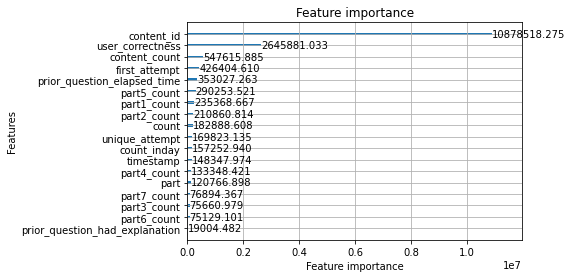

In [21]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])

if FULL_TRAIN:
    model = lgb.train(
        params, 
        tr_data, 
        num_boost_round=4000,
        valid_sets=None, 
        )
else:
    va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

    model = lgb.train(
        params, 
        tr_data, 
        num_boost_round=10000,
        valid_sets=[tr_data, va_data], 
        early_stopping_rounds=50,
        verbose_eval=50
        )

    lgb.plot_importance(model, importance_type='gain')
    plt.show()

# Inference

In [22]:
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [23]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        parts = prior_part_arrays
        prior_first_attempts = prior_f_attempt_arrays
        
        for user_id, content_id, answered_correctly, part, first_attempt_ornot in zip(user_ids, content_ids, targets, parts, prior_first_attempts):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1
            if part == 1:
                part1_count_dict[user_id] +=1
            elif part == 2:
                part2_count_dict[user_id] +=1
            elif part == 3:
                part3_count_dict[user_id] +=1
            elif part == 4:
                part4_count_dict[user_id] +=1
            elif part == 5:
                part5_count_dict[user_id] +=1
            elif part == 6:
                part6_count_dict[user_id] +=1
            else:
                part7_count_dict[user_id] +=1
            user_unique_dict[user_id] += first_attempt_ornot

    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    test_df['timestamp'] = (test_df['timestamp'] // 86400000) + 1
    
    prior_part_arrays = test_df['part'].values
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    part1_count = np.zeros(len(test_df), dtype=np.int32)
    part2_count = np.zeros(len(test_df), dtype=np.int32)
    part3_count = np.zeros(len(test_df), dtype=np.int32)
    part4_count = np.zeros(len(test_df), dtype=np.int32)
    part5_count = np.zeros(len(test_df), dtype=np.int32)
    part6_count = np.zeros(len(test_df), dtype=np.int32)
    part7_count = np.zeros(len(test_df), dtype=np.int32)
    user_count_inday = np.zeros(len(test_df), dtype=np.int32)
    first_attempt_values = []
    user_unique_count = np.zeros(len(test_df), dtype=np.int32)
    
    for i, (user_id, content_id, timestamp) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values, test_df['timestamp'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]
        part1_count[i] = part1_count_dict[user_id]
        part2_count[i] = part2_count_dict[user_id]
        part3_count[i] = part3_count_dict[user_id]
        part4_count[i] = part4_count_dict[user_id]
        part5_count[i] = part5_count_dict[user_id]
        part6_count[i] = part6_count_dict[user_id]
        part7_count[i] = part7_count_dict[user_id]
        first_attempt_values.append(user_content_dict[user_id][content_id])
        user_content_dict[user_id][content_id] = False 
        if user_timestamp_dict[user_id] == timestamp:
            user_count_inday_dict[user_id] += 1
        else:
            user_count_inday_dict[user_id] = 1
            user_timestamp_dict[user_id] = timestamp
        user_count_inday[i] = user_count_inday_dict[user_id]
        user_unique_count[i] = user_unique_dict[user_id]
            
    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
    test_df['count'] = 1
    test_df['count'] = test_df.groupby("user_id")["count"].cumsum()
    test_df['count'] += user_count
    test_df['part1_count'] = part1_count
    test_df['part2_count'] = part2_count
    test_df['part3_count'] = part3_count
    test_df['part4_count'] = part4_count
    test_df['part5_count'] = part5_count
    test_df['part6_count'] = part6_count
    test_df['part7_count'] = part7_count
    test_df["first_attempt"] = first_attempt_values
    test_df['count_inday'] = user_count_inday
    test_df["unique_attempt"] = test_df.groupby("user_id")["first_attempt"].cumsum()
    test_df["unique_attempt"] += user_unique_count
    #test_df['part_count_std'] = np.std(test_df[["part1_count", "part2_count", "part3_count", "part4_count", "part5_count", "part6_count", "part7_count"]], axis=1)

    prior_f_attempt_arrays = test_df['first_attempt'].values
     
    test_df[target] = model.predict(test_df[features])
    env.predict(test_df[['row_id', target]])

CPU times: user 1.16 s, sys: 95.8 ms, total: 1.25 s
Wall time: 968 ms
